### Analyzing Initial BCI Runs

In [181]:
from scipy.stats import qmc
import numpy as np
import xarray as xr
import csv
import pandas as pd
import os
import netCDF4 as nc4
import sys
from tempfile import TemporaryFile                                                                                                                                 
import argparse                                                                                                                                                     
import shutil                                                                                                                                                       
import tempfile 
import random
import math

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib.colors import BoundaryNorm

import functions_py.fates_xarray_functions as fa

dark = cm.get_cmap('Paired', 12)
colormap = dark(range(12))
colormap[10] = colormap[11]

/var/folders/30/fzgs75l559g5v3hbrhqnl3kr0000gq/T/ipykernel_58712/2118807946.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  dark = cm.get_cmap('Paired', 12)


In [222]:
#example fates run
fates = '/Users/sharmiladey/Desktop/bci_p0.Eb645be3aa2-F46cf01a4.2023-05-10.elm.h0.example_run.nc'
fates = xr.open_dataset(fates, decode_times=False)

#time = (fates.variables['time'].isel(time=slice(25,100)) / 365) - 10

#piponiot data https://onlinelibrary.wiley.com/doi/abs/10.1111/nph.17995
pip = pd.read_csv('/Users/sharmiladey/Downloads/Piponiot_2022_NewPhyt_AGB_AWP_AWM_standard_size_class.csv')
pip = pip[(pip.site == "BCI")]

#aboveground biomass
pip_agb = pip[(pip.variable == "AGB")]
#aboveground woody productivity
pip_awp = pip[(pip.variable == "AWP")]
#aboveground woody mortality
pip_awm = pip[(pip.variable == "AWM")]

#fates run at bci with 1 pft
bci1 = '/Users/sharmiladey/Desktop/bci_trendy_dben_1pft.Eb645be3aa2-F14b1791a.2023-06-19.elm.h0.fullrun.nc'
bci1 = xr.open_dataset(bci1, decode_times=False)
bci1time = (bci1.variables['time'] / 12)
bci1time = bci1time.isel(time=slice(250,300))

#fates run at bci with 2 pfts
bci2 = '/Users/sharmiladey/Desktop/bci_trendy_dben_2pfts.Eb645be3aa2-F14b1791a.2023-06-20.elm.h0.sofar.nc'
bci2 = xr.open_dataset(bci2, decode_times=False)
bci2time = (bci2.variables['time'] / 12)
bci2time = bci2time.isel(time=slice(250,300))

#fates ensemble run at bci (missing some variables) run for 301 years
bcie = '/Users/sharmiladey/Desktop/bci_ensemble_2pfts_vert_scaling.Eb645be3aa2-Fe445bf49.2023-06-23.h0.ensemble.sofar.nc'
bcie = xr.open_dataset(bcie, decode_times=False)
bcietime = bcie.variables['time'] / 365

#fates ensemble run at bci run for ___ years
bcie2 = '/Users/sharmiladey/Desktop/bci_ensemble_2pfts_vert_scaling.Eb645be3aa2-Fe445bf49.2023-06-27.h0.ensemble.sofar.nc'
bcie2 = xr.open_dataset(bcie2, decode_times=False)
bcie2time = bcie2.variables['time'] / 365

print(bcie2.data_vars)
#print(bcietime)

Data variables:
    fates_scmap_levscag               (record, fates_levscag) int32 ...
    fates_agmap_levscag               (record, fates_levscag) int32 ...
    fates_pftmap_levscpf              (record, fates_levscpf) int32 ...
    fates_scmap_levscpf               (record, fates_levscpf) int32 ...
    fates_pftmap_levcapf              (record, fates_levcapf) int32 ...
    fates_camap_levcapf               (record, fates_levcapf) int32 ...
    fates_levleaf                     (record, lndgrid) int32 ...
    fates_canmap_levcnlf              (record, fates_levcnlf) int32 ...
    fates_lfmap_levcnlf               (record, fates_levcnlf) int32 ...
    fates_canmap_levcnlfpf            (record, fates_levcnlfpf) int32 ...
    fates_lfmap_levcnlfpf             (record, fates_levcnlfpf) int32 ...
    fates_pftmap_levcnlfpf            (record, fates_levcnlfpf) int32 ...
    fates_scmap_levscagpft            (record, fates_levscagpf) int32 ...
    fates_agmap_levscagpft            (record,

### LAI vs Respiration

('record', 'time', 'lndgrid')
('record', 'time')


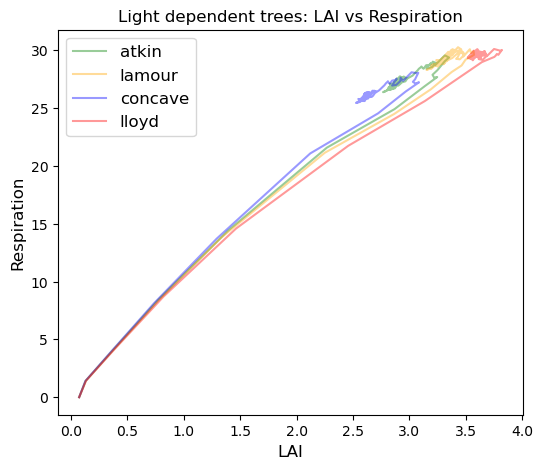

In [183]:
lai = bcie2.FATES_LAI
#lai = lai.mean(dim='time')

resp = bcie2.FATES_AUTORESP_SZPF
resp = fa.scpf_to_scls_by_pft(resp, bcie2) * (10000 / 1000) * (86400*365)
resp = np.squeeze(resp.sum(dim='fates_levpft'))
resp = np.squeeze(resp.sum(dim='fates_levscls'))
ninst = len(bcie2.variables['lon'])
#resp = resp.mean(dim='time') * (10000 / 1000) * (86400*365)

print(lai.dims)
print(resp.dims)

fig1, (f1ax0) = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))

#atkin
f1ax0.plot(lai[0,:], resp[0,:], color='green', label='atkin', alpha = 0.4)
f1ax0.plot(lai[1,:], resp[1,:], color='orange', label='lamour', alpha = 0.4)
f1ax0.plot(lai[2,:], resp[2,:], color='blue', label='concave', alpha=0.4)
f1ax0.plot(lai[3,:], resp[3,:], color='red', label='lloyd', alpha=0.4)
f1ax0.set_title(r'Light dependent trees: LAI vs Respiration', fontsize=12)
f1ax0.set_xlabel(r'LAI', fontsize=12)
f1ax0.set_ylabel(r'Respiration', fontsize=12)
f1ax0.legend(prop={'size':12})

Text(0.5, 0, 'Cumulative LAI')

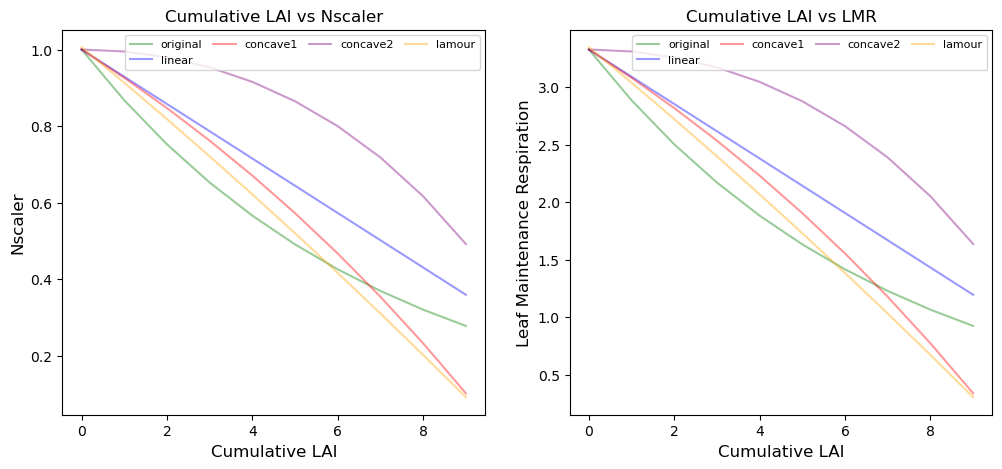

In [187]:
#redoing the respiration curves
#code is from FatesPlantRespPhotosynthMod.F90 and FatesAllometryMod.F90

#Original LAI vs Nscaler (Lloyd)
#exp calculated with decay_coeff_kn in FatesAllometryMod.F90 using vcmax25top = 50
exp0 = (0.00963 * 50 - 2.43)
kn0 = pow(math.e, exp0)
#cumulative lai is a string of numbers from 1 to 10
cumulative_lai0 = np.array(range(0,10))
#nscaler calculated from FatesPlantRespPhotosynthMod.F90
nscaler0 = math.e ** (-kn0 * cumulative_lai0)

#lnc_top from FatesPlantRespPhotosynthMod.F90 - using a constant for everything
lnc_top0  = 0.033/0.012

#from FatesPlantRespPhotosynthMod.F90 (tgrowth = 289.15, veg_tempk = 298.15)
r_t_ref0 = nscaler0 * (1.7560 + 0.2061 * lnc_top0 + 0.0402 * max(0.0, (298.15 - 273.15)))
lmr0 = r_t_ref0 * (math.e**(0.1012 * (298.15 - 273.15 - 25.0) + -0.0005 * ((298.15-273.15)**2 - 25.0**2)))

#---------------------
#LAI vs Nscaler linear
exp1 = (0.00963 * 50 - 2.43)
kn1 = pow(math.e, exp1)
cumulative_lai1 = np.array(range(0,10)) 
#nscaler made to be linear
nscaler1 = (-kn1 * cumulative_lai1)/2 + 1

lnc_top1  = 0.033/0.012

r_t_ref1 = nscaler1 * (1.7560 + 0.2061 * lnc_top1 + 0.0402 * max(0.0, (298.15 - 273.15)))
lmr1 = r_t_ref1 * math.e**(0.1012 * (298.15 - 273.15 - 25.0) + -0.0005 * ((298.15-273.15)**2 - 25.0**2))

#---------------------
#LAI vs Nscaler concave down narrow
exp2 = (0.00963 * 50 - 2.43)
kn2 = pow(math.e, exp2)
cumulative_lai2 = np.array(range(0,10))
#exponent changed to look concave down
nscaler2 = -math.e ** (.5*kn2 * cumulative_lai2)+2

lnc_top2  = 0.033/0.012

r_t_ref2 = nscaler2 * (1.7560 + 0.2061 * lnc_top2 + 0.0402 * max(0.0, (298.15 - 273.15)))
lmr2 = r_t_ref2 * math.e**(0.1012 * (298.15 - 273.15 - 25.0) + -0.0005 * ((298.15-273.15)**2 - 25.0**2))

#---------------------
#LAI vs Nscaler concave down wide
exp4 = (0.00963 * 50 - 2.43)
kn4 = pow(math.e, exp4)
cumulative_lai4 = np.array(range(0,10)) 
nscaler4 = -math.e ** pow(0.5*kn4 * cumulative_lai4, 2)+2

lnc_top4  = 0.033/0.012

r_t_ref4 = nscaler4 * (1.7560 + 0.2061 * lnc_top4 + 0.0402 * max(0.0, (298.15 - 273.15)))
lmr4 = r_t_ref4 * math.e**(0.1012 * (298.15 - 273.15 - 25.0) + -0.0005 * ((298.15-273.15)**2 - 25.0**2))

#ngtpa_eq = -0.1541*x^2 + 0.03091*x + 2.572

#---------------------
#Lamour 
cumulative_lai5 = np.array(range(0,10)) 
nscaler5 = -0.00109 * (cumulative_lai5**2) - 0.09185*cumulative_lai5 + 1.006

lnc_top5  = 0.033/0.012

r_t_ref5 = nscaler5 * (1.7560 + 0.2061 * lnc_top5 + 0.0402 * max(0.0, (298.15 - 273.15)))
lmr5 = r_t_ref5 * math.e**(0.1012 * (298.15 - 273.15 - 25.0) + -0.0005 * ((298.15-273.15)**2 - 25.0**2))


fig1, (f1ax0, f1ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

f1ax0.plot(cumulative_lai0, nscaler0, color='green', label='original', alpha=0.4)
f1ax0.plot(cumulative_lai1, nscaler1, color='blue', label='linear', alpha=0.4)
f1ax0.plot(cumulative_lai2, nscaler2, color='red', label='concave1', alpha=0.4)
#f1ax0.plot(cumulative_lai3, nscaler3, color='black', label='bexp', alpha=0.4)
f1ax0.plot(cumulative_lai4, nscaler4, color='purple', label='concave2', alpha=0.4)
f1ax0.plot(cumulative_lai5, nscaler5, color='orange', label='lamour', alpha=0.4)
#f1ax0.plot(cumulative_lai6, nscaler6, color='red', label='tses2', alpha=0.4)
f1ax0.legend(loc='upper right', ncols=4, fontsize = 8, columnspacing = 1, alignment='right')
f1ax0.set_title(r'Cumulative LAI vs Nscaler', fontsize=12)
f1ax0.set_ylabel(r'Nscaler', fontsize=12)
f1ax0.set_xlabel(r'Cumulative LAI', fontsize=12)

f1ax1.plot(cumulative_lai0, lmr0, color='green', label='original', alpha=0.4)
f1ax1.plot(cumulative_lai1, lmr1, color='blue', label='linear', alpha=0.4)
f1ax1.plot(cumulative_lai2, lmr2, color='red', label='concave1', alpha=0.4)
#f1ax1.plot(cumulative_lai3, lmr3, color='black', label='bexp', alpha=0.4)
f1ax1.plot(cumulative_lai4, lmr4, color='purple', label='concave2', alpha=0.4)
f1ax1.plot(cumulative_lai5, lmr5, color='orange', label='lamour', alpha=0.4)
#f1ax1.plot(cumulative_lai6, lmr6, color='red', label='tses2', alpha=0.4)
f1ax1.legend(loc='upper right', ncols=4, fontsize=8, columnspacing=1, alignment='right')
f1ax1.set_title(r'Cumulative LAI vs LMR', fontsize=12)
f1ax1.set_ylabel(r'Leaf Maintenance Respiration', fontsize=12)
f1ax1.set_xlabel(r'Cumulative LAI', fontsize=12)

#####PREDICTION: concave down wide or lamour schemes are going to be the best fit because 
#####they are the most dissimilar from the original. These schemes will result in the most biomass.

### Ensemble Run AGB

''

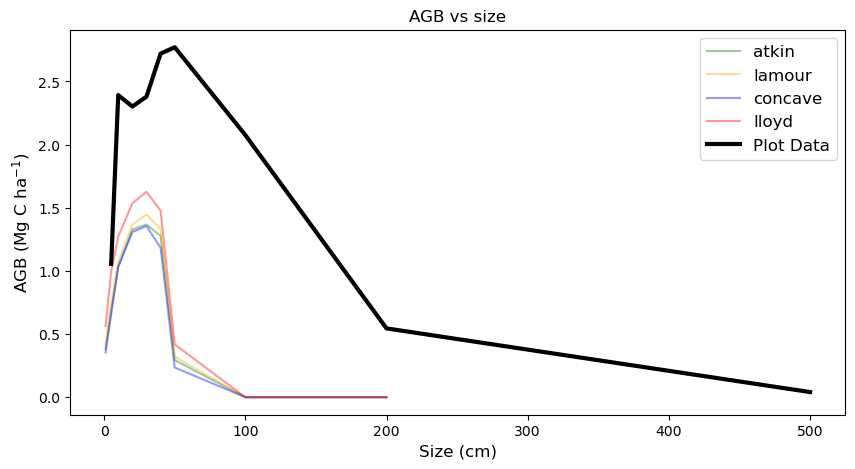

In [197]:
#ensemble run agb 

AGB = bcie2.FATES_VEGC_ABOVEGROUND_SZPF
bci_agb = fa.scpf_to_scls_by_pft(AGB, bcie2)
bci_agb = np.squeeze(bci_agb.sum(dim='fates_levpft'))
bci_agb = bci_agb.isel(fates_levscls=slice(1,500))
ninst = len(bcie2.variables['lon'])
bci_agb = bci_agb.mean(dim='time') * (10000 / 1000)

#size class width bins for the piponiot data
scwidth = [4, 5, 10, 10, 10, 10, 50, 100, 300]
#size class width bins for the fates data
bcisw = [4, 5, 10, 10, 10, 10, 50, 100, 300]

bci_agb = bci_agb/bcisw

fig1, ((f1ax0)) = plt.subplots(nrows=1,ncols=1, figsize=(10,5))

f1ax0.plot(bci_agb.fates_levscls, bci_agb[0,:], color='green', label='atkin', alpha = 0.4)
f1ax0.plot(bci_agb.fates_levscls, bci_agb[1,:], color='orange', label='lamour', alpha = 0.4)
f1ax0.plot(bci_agb.fates_levscls, bci_agb[2,:], color='blue', label='concave', alpha=0.4)
f1ax0.plot(bci_agb.fates_levscls, bci_agb[3,:], color='red', label='lloyd', alpha=0.4) 

f1ax0.plot(pip_agb.size_class.astype(float), pip_agb.total / scwidth, color='black', 
           label = 'Plot Data', linewidth = 3)

f1ax0.set_title(r'AGB vs size', fontsize = 12)
f1ax0.set_ylabel(r'AGB (Mg C ha$^{-1}$)', fontsize = 12)
f1ax0.set_xlabel(r'Size (cm)', fontsize = 12)   
   
#time_plot = pip_agb
#agb_plot = np.squeeze(pip_agb.total) / scwidth

#f1ax0.plot(agb_plot, color='black', label = 'Plot Data')

f1ax0.legend(prop={'size':12})
;

#CONCLUSIONS: Lloyd has the most biomass (original model), then Lamour, full Atkin, concave. 
#It makes sense that Lloyd and concave have opposite reactions because they are the most different
#from each other. All of the curves are greatly underestimating biomass

3
3


''

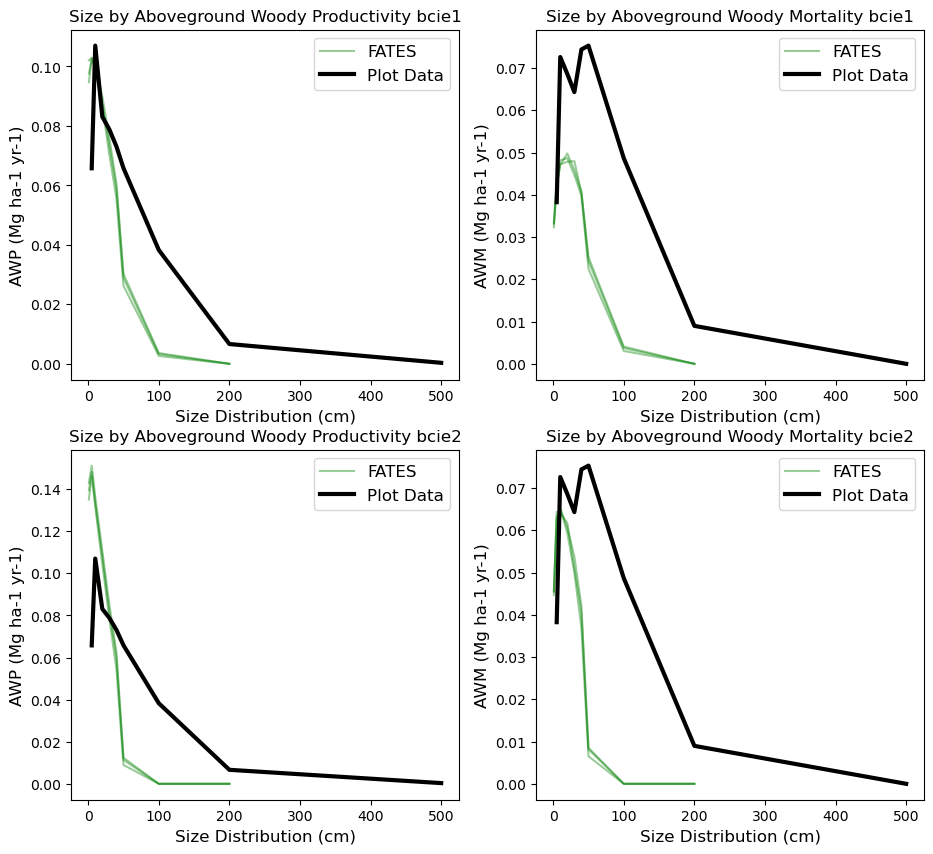

In [242]:
#first FATES ensemble run at BCI (301 years) vs second FATES ensemble run at BCI ()
#pretty good fit for awp and slightly less good fit for awm

#Jessica's rmse definition
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

#defining time
nyears = int(len(bcie.variables['time']))
tave_start = 0
tave_stop  = nyears

#size class width bins for the piponiot data
scwidth = [4, 5, 10, 10, 10, 10, 50, 100, 300]
#size class width bins for the fates data
bcisw = [4, 5, 10, 10, 10, 10, 50, 100, 300]

#aboveground woody productivity for old bcie
bci_awp = bcie.FATES_ABOVEGROUND_PROD_SZPF 
bci_awp = fa.scpf_to_scls_by_pft(bci_awp, bcie)
#summing over pft
bci_awp = np.squeeze(bci_awp.sum(dim='fates_levpft'))
#getting rid of the first size class to match piponiot data
bci_awp = bci_awp.isel(fates_levscls=slice(1,500))
# convert to kg ha-1 yr-1 from kg m-2 s-1
bci_awp = bci_awp.mean(dim='time') * (10000 / 1000) * (86400*365)

#aboveground woody productivity for new bcie2
bci_awp2 = bcie2.FATES_ABOVEGROUND_PROD_SZPF
bci_awp2 = fa.scpf_to_scls_by_pft(bci_awp2, bcie2)
bci_awp2 = np.squeeze(bci_awp2.sum(dim='fates_levpft'))
bci_awp2 = bci_awp2.isel(fates_levscls=slice(1,500))
bci_awp2 = bci_awp2.mean(dim='time') * (10000 / 1000) * (86400*365)

#aboveground woody mortality for old bcie
bci_awm = bcie.FATES_ABOVEGROUND_MORT_SZPF
bci_awm = fa.scpf_to_scls_by_pft(bci_awm, bcie)
bci_awm = np.squeeze(bci_awm.sum(dim='fates_levpft'))
bci_awm = bci_awm.isel(fates_levscls=slice(1,500))
bci_awm = bci_awm.mean(dim='time') * (10000 / 1000) * (86400*365)

#aboveground woody mortality for new bcie2
bci_awm2 = bcie2.FATES_ABOVEGROUND_MORT_SZPF
bci_awm2 = fa.scpf_to_scls_by_pft(bci_awm2, bcie2)
bci_awm2 = np.squeeze(bci_awm2.sum(dim='fates_levpft'))
bci_awm2 = bci_awm2.isel(fates_levscls=slice(1,500))
bci_awm2 = bci_awm2.mean(dim='time') * (10000 / 1000) * (86400*365)

#divide by the size bins
bci_awp = bci_awp / bcisw
bci_awm = bci_awm / bcisw
bci_awp2 = bci_awp2 / bcisw
bci_awm2 = bci_awm2 / bcisw

#PLOT
fig2, ((f2ax0, f2ax1), (f2ax2, f2ax3)) = plt.subplots(nrows=2,ncols=2, figsize=(11,10))

for  i in range(0,3):
    if i == 0: 
        f2ax0.plot(bci_awp.fates_levscls, bci_awp[i,:], color='green', 
                  label = 'FATES', alpha = 0.4)
        f2ax1.plot(bci_awm.fates_levscls, bci_awm[i,:], color='green', 
                  label = 'FATES', alpha = 0.4)
        f2ax2.plot(bci_awp2.fates_levscls, bci_awp2[i,:], color='green', 
                  label = 'FATES', alpha = 0.4)
        f2ax3.plot(bci_awm2.fates_levscls, bci_awm2[i,:], color='green', 
                  label = 'FATES', alpha = 0.4)
    else: 
        f2ax0.plot(bci_awp.fates_levscls, bci_awp[i,:], color='green', alpha = 0.4)
        f2ax1.plot(bci_awm.fates_levscls, bci_awm[i,:], color='green', alpha = 0.4)
        f2ax2.plot(bci_awp2.fates_levscls, bci_awp2[i,:], color='green', alpha = 0.4)
        f2ax3.plot(bci_awm2.fates_levscls, bci_awm2[i,:], color='green', alpha = 0.4)

#Aboveground woody productivity for old bcie
f2ax0.plot(pip_awp.size_class.astype(float), pip_awp.total / scwidth, color='black', 
           label = 'Plot Data', linewidth = 3)        
f2ax0.set_title(r'Size by Aboveground Woody Productivity bcie1', fontsize=12)
f2ax0.set_xlabel(r'Size Distribution (cm)', fontsize=12)
f2ax0.set_ylabel(r'AWP (Mg ha-1 yr-1)', fontsize=12)
f2ax0.legend(prop={'size':12})

#Aboveground woody mortality for old bcie
f2ax1.plot(pip_awm.size_class.astype(float), pip_awm.total / scwidth, color='black', 
           label = 'Plot Data', linewidth = 3)
f2ax1.set_title(r'Size by Aboveground Woody Mortality bcie1', fontsize=12)
f2ax1.set_xlabel(r'Size Distribution (cm)', fontsize=12)
f2ax1.set_ylabel(r'AWM (Mg ha-1 yr-1)', fontsize=12)
f2ax1.legend(prop={'size':12})

#Aboveground woody productivity for new bcie2
f2ax2.plot(pip_awp.size_class.astype(float), pip_awp.total / scwidth, color='black', 
           label = 'Plot Data', linewidth = 3)
f2ax2.set_title(r'Size by Aboveground Woody Productivity bcie2', fontsize=12)
f2ax2.set_xlabel(r'Size Distribution (cm)', fontsize=12)
f2ax2.set_ylabel(r'AWP (Mg ha-1 yr-1)', fontsize=12)
f2ax2.legend(prop={'size':12})

#Aboveground woody mortality for new bcie 2
f2ax3.plot(pip_awm.size_class.astype(float), pip_awm.total / scwidth, color='black', 
           label = 'Plot Data', linewidth = 3)
f2ax3.set_title(r'Size by Aboveground Woody Mortality bcie2', fontsize=12)
f2ax3.set_xlabel(r'Size Distribution (cm)', fontsize=12)
f2ax3.set_ylabel(r'AWM (Mg ha-1 yr-1)', fontsize=12)
f2ax3.legend(prop={'size':12})

#RMSE from Jessica for AWP
rmse_sizedist = []
for i in range(0,4):
    rmse_sizedist.append(rmse(pip_awp.total, bci_awp2[i,:]))
    
sizedist_best = rmse_sizedist.index(min(rmse_sizedist)) 
print(sizedist_best)

#RMSE for AWM
for i in range(0,4):
    rmse_sizedist.append(rmse(pip_awm.total, bci_awm2[i,:]))
    
sizedist_best = rmse_sizedist.index(min(rmse_sizedist)) 
print(sizedist_best)
;

#CONCLUSIONS: concave is the best fit for both awp and awm for both ensemble runs

### Net Carbon Uptake by Leaf Layer

(0.0, 0.8)

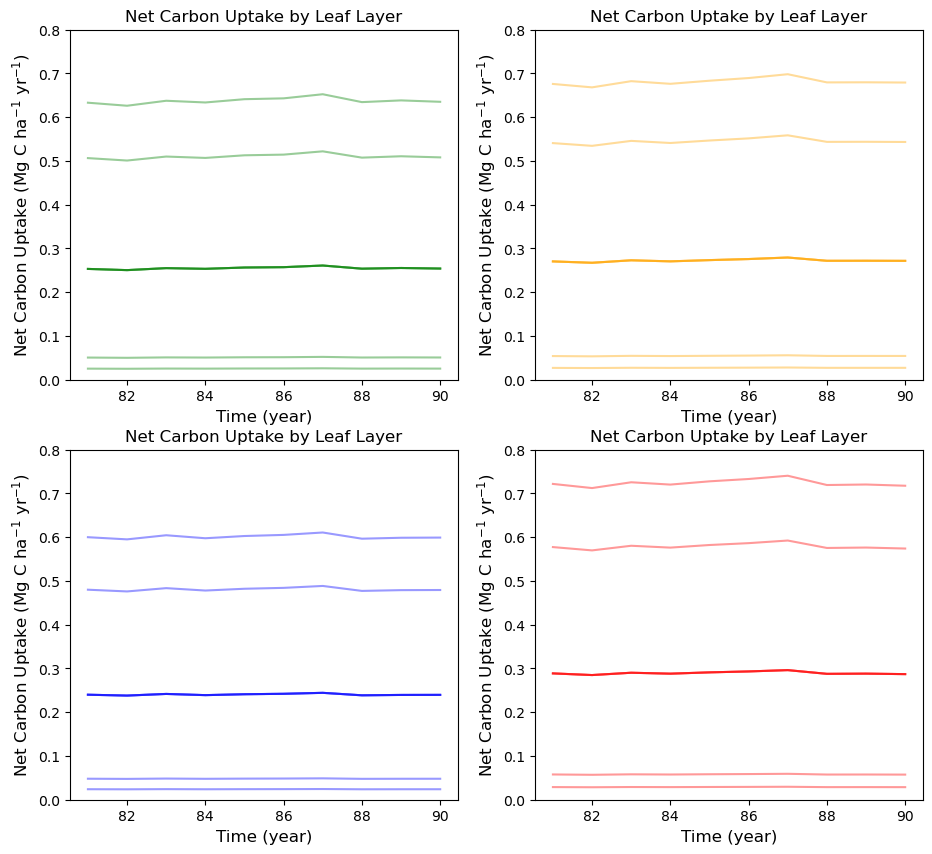

In [257]:
#number of plants by size by year

nyears = int(len(bcie2.variables['time']))

netc = bcie2.FATES_NET_C_UPTAKE_CLLL.isel(time=slice(nyears-10,nyears))
netc = netc.mean(dim='fates_levcnlf') * 10000 / 1000 * (86400*365)

bcisw = [4, 5, 10, 10, 10, 10, 50, 100, 300]

netc = netc/bcisw

fig1, ((f1ax0, f1ax1), (f1ax2, f1ax3)) = plt.subplots(nrows=2,ncols=2, figsize=(11,10))

for  i in range(0,8):
    if i == 0:
        f1ax0.plot(bcie2time.isel(time=slice(nyears-10,nyears)), netc[0,:,i], color='green',
                   label='atkin', alpha = 0.4)
        f1ax1.plot(bcie2time.isel(time=slice(nyears-10,nyears)), netc[1,:,i], color='orange',
                   label='lamour', alpha = 0.4)
        f1ax2.plot(bcie2time.isel(time=slice(nyears-10,nyears)), netc[2,:,i], color='blue',
                   label='concave', alpha=0.4)
        f1ax3.plot(bcie2time.isel(time=slice(nyears-10,nyears)), netc[3,:,i], color='red',
                   label='lloyd', alpha=0.4)
    else: 
        f1ax0.plot(bcie2time.isel(time=slice(nyears-10,nyears)), netc[0,:,i], color='green', alpha = 0.4)
        f1ax1.plot(bcie2time.isel(time=slice(nyears-10,nyears)), netc[1,:,i], color='orange', alpha = 0.4)
        f1ax2.plot(bcie2time.isel(time=slice(nyears-10,nyears)), netc[2,:,i], color='blue', alpha=0.4)
        f1ax3.plot(bcie2time.isel(time=slice(nyears-10,nyears)), netc[3,:,i], color='red', alpha=0.4)


f1ax0.set_title(r'Net Carbon Uptake by Leaf Layer', fontsize = 12)
f1ax0.set_ylabel(r'Net Carbon Uptake (Mg C ha$^{-1}$ yr$^{-1}$)', fontsize = 12)
f1ax0.set_xlabel(r'Time (year)', fontsize = 12)
f1ax0.set_ylim(0, .8)

f1ax1.set_title(r'Net Carbon Uptake by Leaf Layer', fontsize = 12)
f1ax1.set_ylabel(r'Net Carbon Uptake (Mg C ha$^{-1}$ yr$^{-1}$)', fontsize = 12)
f1ax1.set_xlabel(r'Time (year)', fontsize = 12)
f1ax1.set_ylim(0, .8)

f1ax2.set_title(r'Net Carbon Uptake by Leaf Layer', fontsize = 12)
f1ax2.set_ylabel(r'Net Carbon Uptake (Mg C ha$^{-1}$ yr$^{-1}$)', fontsize = 12)
f1ax2.set_xlabel(r'Time (year)', fontsize = 12)
f1ax2.set_ylim(0, .8)

f1ax3.set_title(r'Net Carbon Uptake by Leaf Layer', fontsize = 12)
f1ax3.set_ylabel(r'Net Carbon Uptake (Mg C ha$^{-1}$ yr$^{-1}$)', fontsize = 12)
f1ax3.set_xlabel(r'Time (year)', fontsize = 12)
f1ax3.set_ylim(0, .8)

### Number of Plants by Size by Year

(0.0, 400.0)

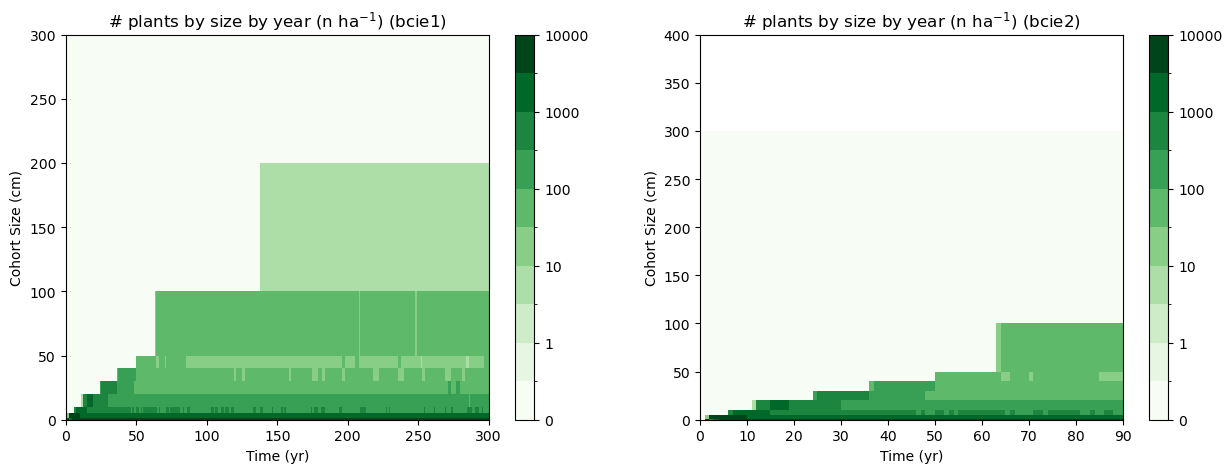

In [234]:
# #plants by size by yr
numplant = bcie.FATES_NPLANT_SZ
numplant2 = bcie2.FATES_NPLANT_SZ
numplant = numplant.isel(time=slice(0,300))*10000
numplant2 = numplant2.isel(time=slice(0,90))*10000

cohort_size_bins = bcie.variables['fates_levscls'].values
cohort_size_bins = np.append(cohort_size_bins,cohort_size_bins[len(cohort_size_bins)-1]*1.5)

levels = np.array([0.1,0.3,1.,3.,10.,30., 100.,300.,1000., 3000., 10000.])
cmap = plt.get_cmap('Greens')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig1, (f1ax0, f1ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

im = f1ax0.pcolormesh(bcietime, cohort_size_bins, (numplant)[1,:,:,0].transpose(), cmap=cmap, norm=norm)
fig1.colorbar(im, ax=f1ax0)
f1ax0.set_title(r'# plants by size by year (n ha$^{-1}$) (bcie1)')
f1ax0.set_xlabel('Time (yr)')
f1ax0.set_ylabel('Cohort Size (cm)')

im2 = f1ax1.pcolormesh(bcie2time, cohort_size_bins, (numplant2)[1,:,:,0].transpose(), cmap=cmap, norm=norm)
fig1.colorbar(im2, ax=f1ax1)
f1ax1.set_title(r'# plants by size by year (n ha$^{-1}$) (bcie2)')
f1ax1.set_xlabel('Time (yr)')
f1ax1.set_ylabel('Cohort Size (cm)')

plt.ylim([0, 400])

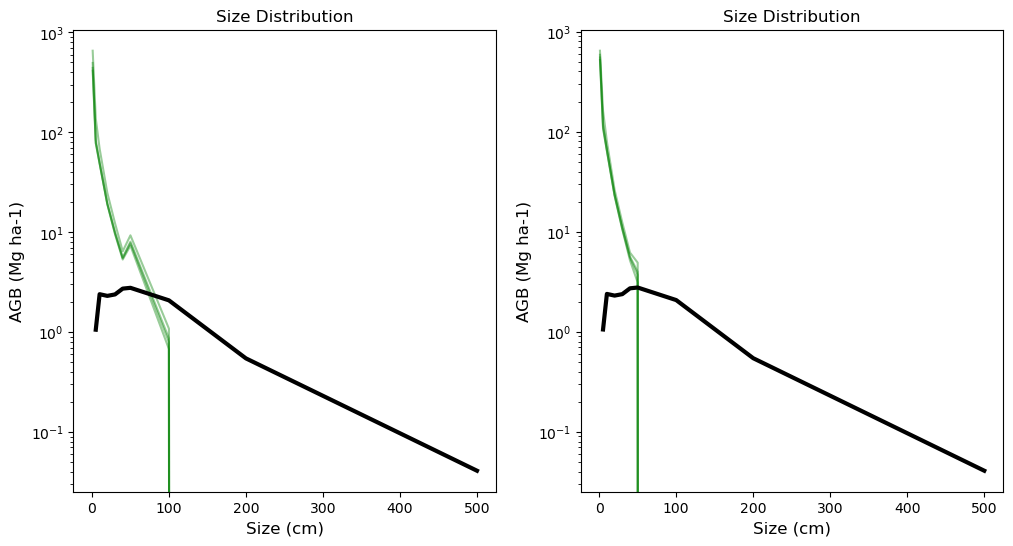

In [238]:
#pip in megagrams need to multiply by 1000 to go from Mg to kg
scwidth = [4, 5, 10, 10, 10, 10, 50, 100, 300]
bcisw = [4, 5, 10, 10, 10, 10, 50, 100, 300]

bcie_np = bcie.FATES_NPLANT_SZ
bcie_np = bcie_np.isel(fates_levscls=slice(1,500))
bcie_np = bcie_np.mean(dim='time')* 10000

bcie_np2 = bcie2.FATES_NPLANT_SZ
bcie_np2 = bcie_np2.isel(fates_levscls=slice(1,500))
bcie_np2 = bcie_np2.mean(dim='time') * 10000

bcie_np = bcie_np/bcisw
bcie_np2 = bcie_np2/bcisw

fig1, (f1ax0, f1ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

for  i in range(0,4):
    if i == 0: 
        f1ax0.plot(bcie_np.fates_levscls, bcie_np[i,:,0], color='green', 
                  label = 'FATES', alpha = 0.4)
        f1ax1.plot(bcie_np2.fates_levscls, bcie_np2[i,:,0], color='green',
                  label = 'FATES', alpha = 0.4)
    else: 
        f1ax0.plot(bcie_np.fates_levscls, bcie_np[i,:,0], color='green', alpha = 0.4)
        f1ax1.plot(bcie_np2.fates_levscls, bcie_np2[i,:,0], color='green', alpha = 0.4)

f1ax0.plot(pip_agb.size_class.astype(float), np.squeeze(pip_agb.total) / scwidth, 
           color='black', label='BCI', linewidth = 3)
f1ax0.set_title(r'Size Distribution', fontsize=12)
f1ax0.set_xlabel(r'Size (cm)', fontsize=12)
f1ax0.set_ylabel(r'AGB (Mg ha-1)', fontsize=12)
f1ax0.set_yscale('log')

f1ax1.plot(pip_agb.size_class.astype(float), np.squeeze(pip_agb.total) / scwidth, 
           color='black', label='BCI', linewidth = 3)
f1ax1.set_title(r'Size Distribution', fontsize=12)
f1ax1.set_xlabel(r'Size (cm)', fontsize=12)
f1ax1.set_ylabel(r'AGB (Mg ha-1)', fontsize=12)
f1ax1.set_yscale('log')

### Net carbon uptake by leaf layer

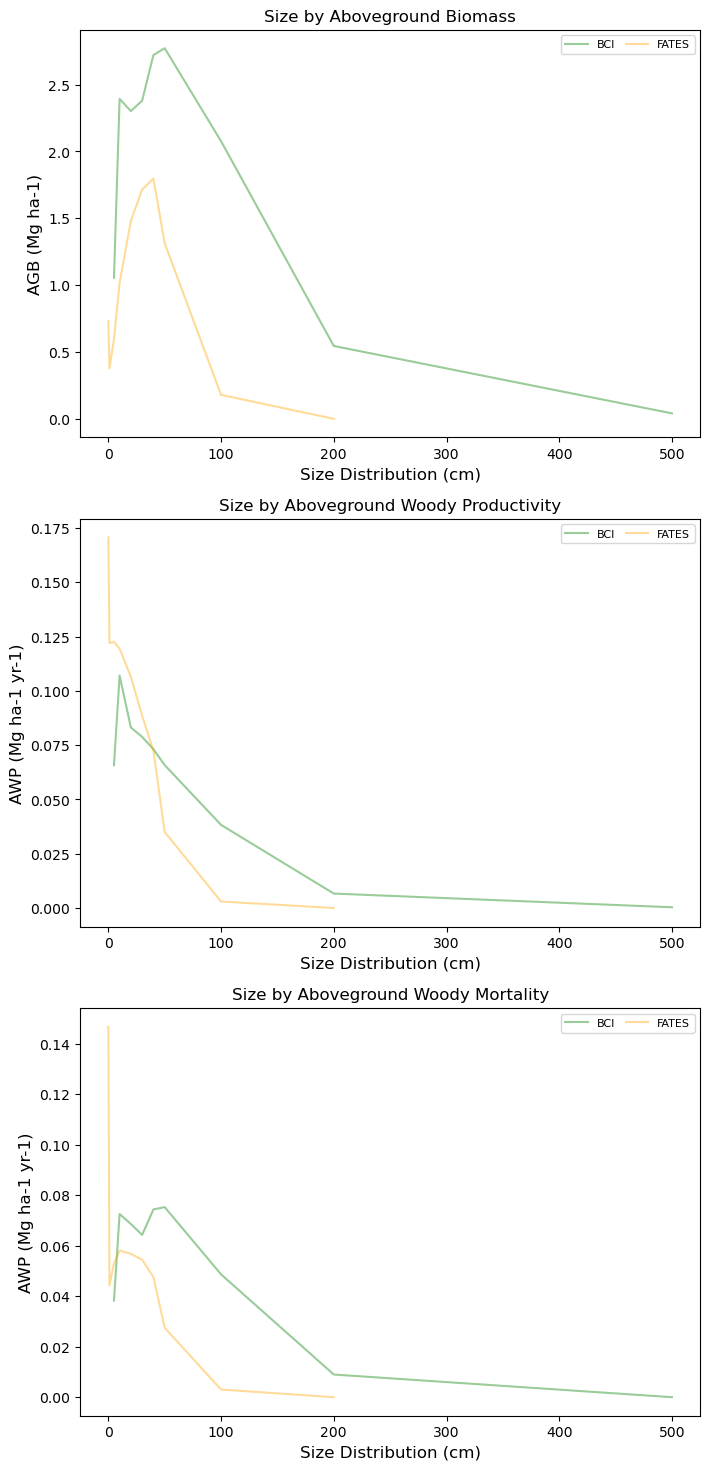

In [32]:
#TESTING VERY FIRST BCI RUN AGAINST PIPONIOT DATA -- OUTDATED
#pip in megagrams need to multiply by 1000 to go from Mg to kg


#creating bins for 
scbins = [1, 5, 10, 20, 30, 40, 50, 100, 200, 500]
scwidth = [4, 5, 10, 10, 10, 10, 50, 100, 300]

bci_agb = bci1.FATES_VEGC_ABOVEGROUND_SZ
bci_agb = bci_agb.mean(dim='time') * 10000 / 1000

bcisc = [0, 1, 5, 10, 20, 30, 40, 50, 100, 200, 500]
bcisw = [1, 4, 5, 10, 10, 10, 10, 50, 100, 300]

adjusted = np.squeeze(bci_agb)/bcisw

bci_awp = bci1.FATES_ABOVEGROUND_PROD_SZPF
bci_awp = fa.scpf_to_scls_by_pft(bci_awp, bci1)
bci_awp = bci_awp.mean(dim='time') * 10000 / 1000 * (86400*365)

bci_awm = bci1.FATES_ABOVEGROUND_MORT_SZPF
bci_awm = fa.scpf_to_scls_by_pft(bci_awm, bci1)
bci_awm = bci_awm.mean(dim='time') * 10000 / 1000 * (86400*365)

fig1, (f1ax0, f1ax1, f1ax2) = plt.subplots(nrows=3, ncols=1, figsize=(8, 18))

f1ax0.plot(pip_agb.size_class.astype(float), np.squeeze(pip_agb.total) / scwidth, 
           color='green', label='BCI', alpha=0.4)
f1ax0.plot(bci_agb.fates_levscls, adjusted, color='orange', label='FATES', alpha=0.4)
f1ax0.set_title(r'Size by Aboveground Biomass', fontsize=12)
f1ax0.set_xlabel(r'Size Distribution (cm)', fontsize=12)
f1ax0.set_ylabel(r'AGB (Mg ha-1)', fontsize=12)
f1ax0.legend(loc='upper right', ncols=4, fontsize = 8, columnspacing = 1, alignment='right')

f1ax1.plot(pip_awp.size_class.astype(float), pip_awp.total / scwidth, color='green', label='BCI', alpha=0.4)
f1ax1.plot(bci_awp.fates_levscls, bci_awp.sel(lndgrid = 0).sel(fates_levpft = 1) / bcisw, 
           color='orange', label='FATES', alpha=0.4)
f1ax1.set_title(r'Size by Aboveground Woody Productivity', fontsize=12)
f1ax1.set_xlabel(r'Size Distribution (cm)', fontsize=12)
f1ax1.set_ylabel(r'AWP (Mg ha-1 yr-1)', fontsize=12)
f1ax1.legend(loc='upper right', ncols=4, fontsize = 8, columnspacing = 1, alignment='right')

f1ax2.plot(pip_awm.size_class.astype(float), pip_awm.total / scwidth, color='green', label='BCI', alpha=0.4)
f1ax2.plot(bci_awm.fates_levscls, bci_awm.sel(fates_levpft = 1).sel(lndgrid = 0) / bcisw, 
           color='orange', label='FATES', alpha=0.4)
f1ax2.set_title(r'Size by Aboveground Woody Mortality', fontsize=12)
f1ax2.set_xlabel(r'Size Distribution (cm)', fontsize=12)
f1ax2.set_ylabel(r'AWP (Mg ha-1 yr-1)', fontsize=12)
f1ax2.legend(loc='upper right', ncols=4, fontsize = 8, columnspacing = 1, alignment='right')

### BCI Model Run plots

<xarray.DataArray 'fates_levscls' (fates_levscls: 10)>
array([  0.,   1.,   5.,  10.,  20.,  30.,  40.,  50., 100., 200.],
      dtype=float32)
Coordinates:
  * fates_levscls  (fates_levscls) float32 0.0 1.0 5.0 10.0 ... 50.0 100.0 200.0
Attributes:
    long_name:  FATES diameter size class lower bound
    units:      cm


Text(0, 0.5, 'Mortality rate due to Carbon Starvation (ha-1 yr-1)')

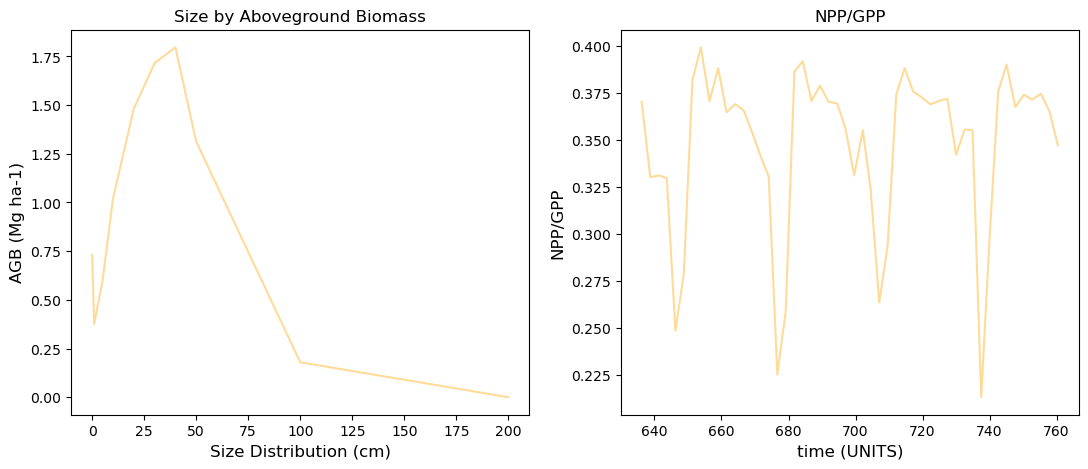

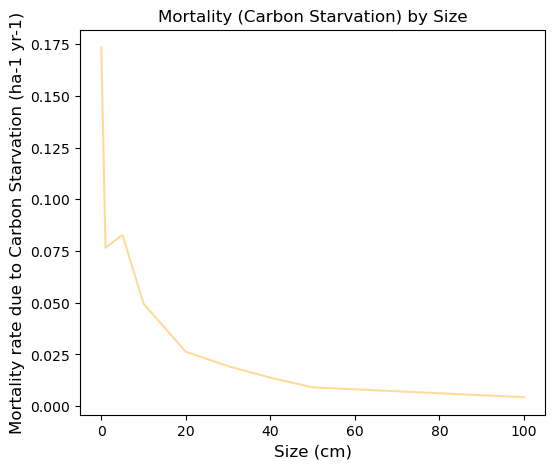

In [5]:
#kg m-2 s-1 -> Mg ha-1 yr-1
#print(bci_agb.fates_levscls)
bci_agb = bci1.FATES_VEGC_ABOVEGROUND_SZ
bci_agb = bci_agb.mean(dim='time') * 10000 / 1000

bcisc = [0, 1, 5, 10, 20, 30, 40, 50, 100, 200, 500]
bcisw = [1, 4, 5, 10, 10, 10, 10, 50, 100, 300]

adjusted = np.squeeze(bci_agb)/bcisw

nyears = int(len(bci1.variables['time'])/12)
tave_start = (nyears-50)
tave_stop  = nyears

bci_npp = bci1.FATES_NPP/(86400*365)
bci_gpp = bci1.FATES_GPP/(86400*365)
bci_npp = (bci1.FATES_NPP).isel(time=slice(tave_start, tave_stop))
bci_gpp = (bci1.FATES_GPP).isel(time=slice(tave_start, tave_stop))

ngpp = bci_npp/bci_gpp

bci_cstarv = bci1.FATES_MORTALITY_CSTARV_SZ * 10000
bci_cstarv = bci_cstarv.mean(dim='time')

print(bci_cstarv.fates_levscls)

bci_pop = bci1.FATES_NPLANT_SZ * 10000
bci_pop = bci_pop.mean(dim='time')

fig1, (f1ax0, f1ax1) = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))

#Biomass
f1ax0.plot(bci_agb.fates_levscls, adjusted, color='orange', label='FATES', alpha=0.4)
f1ax0.set_title(r'Size by Aboveground Biomass', fontsize=12)
f1ax0.set_xlabel(r'Size Distribution (cm)', fontsize=12)
f1ax0.set_ylabel(r'AGB (Mg ha-1)', fontsize=12)

f1ax1.plot(bci1time, ngpp, color="orange", alpha=0.4)
f1ax1.set_title(r'NPP/GPP', fontsize=12)
f1ax1.set_xlabel(r'time (UNITS)', fontsize=12)
f1ax1.set_ylabel(r'NPP/GPP', fontsize=12)

fig2, (f2ax0) = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))

f2ax0.plot(bci_cstarv.fates_levscls, bci_cstarv/bci_pop, color='orange', alpha=0.4)
f2ax0.set_title(r'Mortality (Carbon Starvation) by Size', fontsize=12)
f2ax0.set_xlabel(r'Size (cm)', fontsize=12)
f2ax0.set_ylabel(r'Mortality rate due to Carbon Starvation (ha-1 yr-1)', fontsize=12)

<xarray.DataArray 'fates_levscls' (fates_levscls: 10)>
array([  0.,   1.,   5.,  10.,  20.,  30.,  40.,  50., 100., 200.],
      dtype=float32)
Coordinates:
  * fates_levscls  (fates_levscls) float32 0.0 1.0 5.0 10.0 ... 50.0 100.0 200.0
Attributes:
    long_name:  FATES diameter size class lower bound
    units:      cm


Text(0, 0.5, 'Mortality rate due to Carbon Starvation (ha-1 yr-1)')

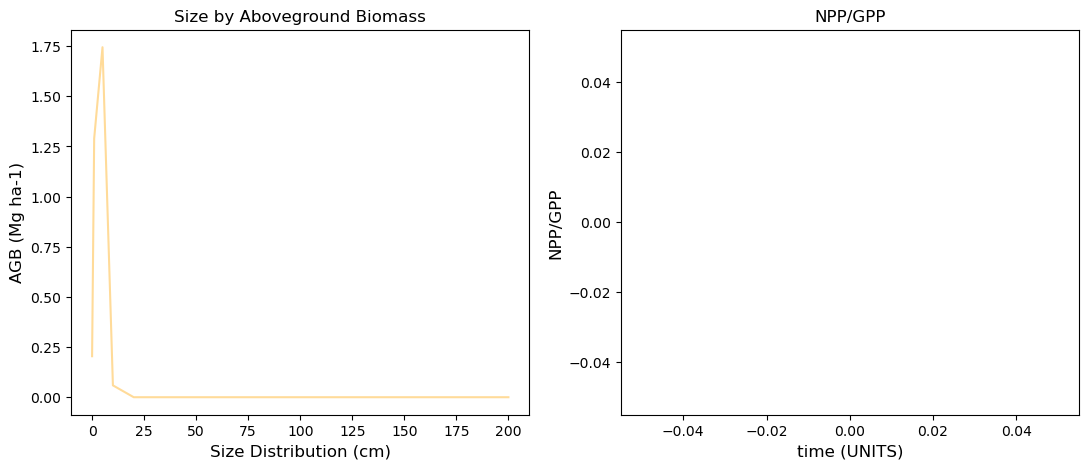

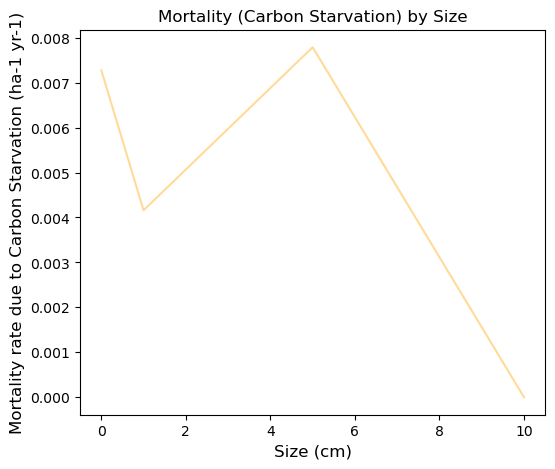

In [6]:
bci_agb = bci2.FATES_VEGC_ABOVEGROUND_SZ
bci_agb = bci_agb.mean(dim='time') * 10000 / 1000

bcisc = [0, 1, 5, 10, 20, 30, 40, 50, 100, 200, 500]
bcisw = [1, 4, 5, 10, 10, 10, 10, 50, 100, 300]

adjusted = np.squeeze(bci_agb)/bcisw

nyears = int(len(bci2.variables['time'])/12)
tave_start = (nyears-50)
tave_stop  = nyears

bci_npp = bci2.FATES_NPP/(86400*365)
bci_gpp = bci2.FATES_GPP/(86400*365)
bci_npp = (bci2.FATES_NPP).isel(time=slice(tave_start, tave_stop))
bci_gpp = (bci2.FATES_GPP).isel(time=slice(tave_start, tave_stop))

ngpp = bci_npp/bci_gpp

bci_cstarv = bci2.FATES_MORTALITY_CSTARV_SZ * 10000
bci_cstarv = bci_cstarv.mean(dim='time')

print(bci_cstarv.fates_levscls)

bci_pop = bci2.FATES_NPLANT_SZ * 10000
bci_pop = bci_pop.mean(dim='time')

fig1, (f1ax0, f1ax1) = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))

#Biomass
f1ax0.plot(bci_agb.fates_levscls, adjusted, color='orange', label='FATES', alpha=0.4)
f1ax0.set_title(r'Size by Aboveground Biomass', fontsize=12)
f1ax0.set_xlabel(r'Size Distribution (cm)', fontsize=12)
f1ax0.set_ylabel(r'AGB (Mg ha-1)', fontsize=12)

f1ax1.plot(bci2time, ngpp, color="orange", alpha=0.4)
f1ax1.set_title(r'NPP/GPP', fontsize=12)
f1ax1.set_xlabel(r'time (UNITS)', fontsize=12)
f1ax1.set_ylabel(r'NPP/GPP', fontsize=12)

fig2, (f2ax0) = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))

f2ax0.plot(bci_cstarv.fates_levscls, bci_cstarv/bci_pop, color='orange', alpha=0.4)
f2ax0.set_title(r'Mortality (Carbon Starvation) by Size', fontsize=12)
f2ax0.set_xlabel(r'Size (cm)', fontsize=12)
f2ax0.set_ylabel(r'Mortality rate due to Carbon Starvation (ha-1 yr-1)', fontsize=12)